In [9]:
import numpy as np
from numpy.random import default_rng
import skimage as ski
import optimizers
import operators
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display
import utils

# Quantifying Uncertainty in a Reconstruction

Assume we have a great, accurate inversion algorithm and with that, we have computed some solution $x^{\ast}$ from the data observation $y$ in the inverse problem 
$$y = A(x) + \varepsilon$$
> How certain are we that $x^{\ast}$ is a representative solution? 
> How large are the errors that we could have made because of the stochastic nature of the noise $\varepsilon$? 

For instance, consider the following example of making two independent CT scans of the same object:

c:\Users\kugerlor\AppData\Local\miniconda3\envs\incubator\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Iteration: 1
Energy: 0.0001468872216692289
Iteration: 2
Energy: 0.00012839899720719426
Iteration: 3
Energy: 0.00011766190586805327
Iteration: 4
Energy: 0.00011154333399187993
Iteration: 5
Energy: 0.00010742281941501325
Iteration: 6
Energy: 0.00010436980751438984
Iteration: 7
Energy: 0.00010197956091450397
Iteration: 8
Energy: 0.00010004499994942275
Iteration: 9
Energy: 9.84416934628012e-05
Iteration: 10
Energy: 9.708334577658329e-05
Iteration: 11
Energy: 9.592104035020733e-05
Iteration: 12
Energy: 9.491163009795885e-05
Iteration: 13
Energy: 9.402618982516595e-05
Iteration: 14
Energy: 9.32430209679068e-05
Iteration: 15
Energy: 9.254484670981675e-05
Iteration: 16
Energy: 9.19156262503031e-05
Iteration: 17
Energy: 9.134412212696231e-05
Iteration: 18
Energy: 9.082204780424615e-05
Iteration: 19
Energy: 9.034693318020597e-05
Iteration: 20
Energy: 8.991277126136234e-05
Iteration: 21
Energy: 8.951308795516988e-05
Iteration: 22
Energy: 8.914486419177502e-05
Iteration: 23
Energy: 8.8803589127677

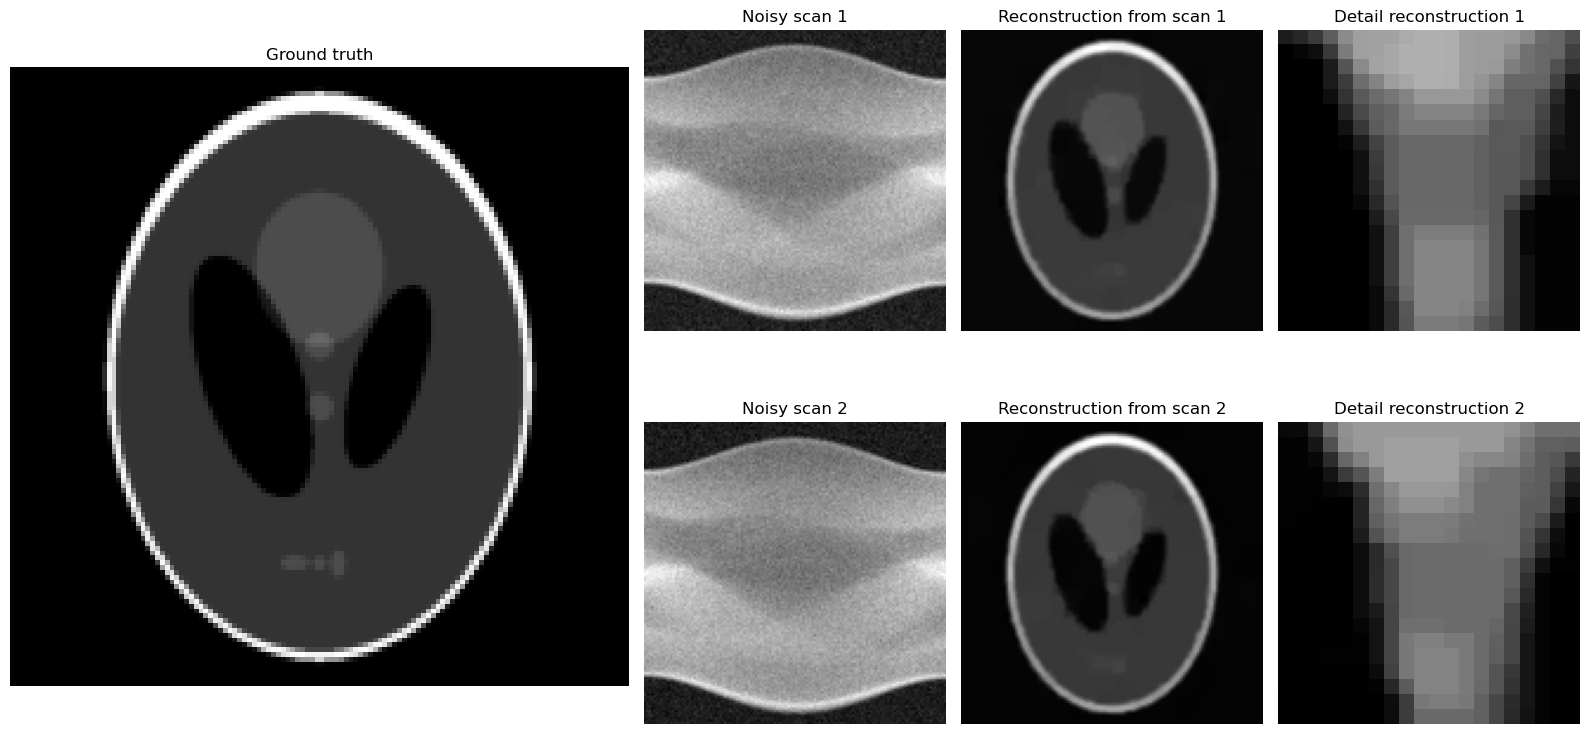

In [74]:
import matplotlib.gridspec as gridspec

rng = default_rng(2452)

fig = plt.figure(tight_layout=True,figsize=(16,8))
gs = gridspec.GridSpec(2, 5)

dim=128
phantom = utils.get_phantom(dim)
theta = np.linspace(0,180, endpoint = False, num=128)
R = operators.Radon(theta=theta)
sinogram = R(phantom)

# two different instantiations of the randomly distributed noise
sigma = 0.01
noise1 = sigma*rng.normal(size=sinogram.shape)
noise2 = sigma*rng.normal(size=sinogram.shape)
y1 = sinogram + noise1
y2 = sinogram + noise2

"""
# forward and backprojection operator
A = lambda x : ski.transform.radon(x,theta,circle=False)
Aadj = lambda sino : ski.transform.iradon(sino,theta,circle=False,filter_name=None)
AtA = lambda x : Aadj(A(x))
max_ev_AtA = power_method(AtA, phantom.shape[0], 1e-4, int(3e2))
"""

mu_tv = 0.005
opt1 = optimizers.split_Bregman_TV(R,y1,np.zeros(phantom.shape),1,mu_tv,max_it=25,verbosity=1,energy_fun=lambda x:np.sqrt(np.sum((R(x)-y1)**2))/dim**2)
opt2 = optimizers.split_Bregman_TV(R,y2,np.zeros(phantom.shape),1,mu_tv,max_it=25,verbosity=1,energy_fun=lambda x:np.sqrt(np.sum((R(x)-y2)**2))/dim**2)

# add two different noise realizations to the sinogram to simulate two independent scans
##rec1 = tv_rec(y1,mu_tv,sigma,phantom.shape,A,Aadj,max_ev_AtA)
##rec2 = tv_rec(y2,mu_tv,sigma,phantom.shape,A,Aadj,max_ev_AtA)
rec1 = opt1.solve()
rec2 = opt2.solve()

# plot results
ax = [fig.add_subplot(gs[:, 0:2])]
for i in range(6): ax.append(fig.add_subplot(gs[i%2,2+i//2]))
ax[0].imshow(phantom, cmap='gray',vmin=0,vmax=1), ax[0].set_title('Ground truth')
ax[1].imshow(y1, cmap='gray'), ax[1].set_title('Noisy scan 1')
ax[2].imshow(y2, cmap='gray'), ax[2].set_title('Noisy scan 2')

# apply TV reconstruction here instead to visualize different smoothing
ax[3].imshow(rec1, cmap='gray'), ax[3].set_title('Reconstruction from scan 1')
ax[4].imshow(rec2, cmap='gray'), ax[4].set_title('Reconstruction from scan 2')
ax[5].imshow(rec1[dim//2-10:dim//2+10,dim//2-10:dim//2+10], cmap='gray', vmin=0, vmax=0.5), ax[5].set_title('Detail rec. 1 (Contrast enhanced)')
ax[6].imshow(rec2[dim//2-10:dim//2+10,dim//2-10:dim//2+10], cmap='gray', vmin=0, vmax=0.5), ax[6].set_title('Detail rec. 2 (Contrast enhanced)')

for axes in ax: axes.axis('off')

In order to answer, we have to give some probabilistic meaning to the distribution of possible solutions $x$, noise $\varepsilon$ and the observed data $y$. We assume that both $x$ and $\varepsilon$ are instantiations of random variables with certain probability distributions. For the marginal distribution of possible solutions, we write $x \sim \pi_0$. The probability of observing $y = A(x)+\varepsilon$ given some $x$ is denoted $\pi_{y|x}$.

$\pi_0$ is called the **prior distribution**, it encodes prior information, assumptions or belief about the possible nature of our reconstruction $x$. Assume that $\pi_0$ has a probability density function (pdf) $p_0(x)$.

The density $p(\cdot|x)$ of the distribution $\pi_{y|x}$ is called the **likelihood**.

Once we make an observation $y$, by **Bayes' law** the **posterior distribution** of $x$ after seeing $y$ has the density
$$ p(x|y) = \frac{p(y|x)p_0(x)}{p(y)} \propto p(y|x) p_0(x). $$

### Prior distribution
Examples
- If we believe our solution $x$ should be close to some a priori known value $\hat x$, then our prior might look something like $p_0(x) = \exp(-\frac{1}{2\sigma^2}||x-\hat x||_2^2)/Z$. The normalization constant $Z$ ensures that $p_0$ is a valid pdf, we omit it from now on and write "$\propto$" for proportionality. According to this prior density, values closer to $\hat x$ are assigned larger probability values, since they are assumed to be more likely.
- If we believe that $x$ is likely to have little edges/contrast jumps, we might pick a prior like $p_0(x) \propto \exp(-\mathrm {TV}(x)) = \exp(- \lVert \nabla x \rVert_1)$.
- In general, distributions of the form $ p_0(x) \propto \exp(-G(x))$ for any $G$ are called **Gibbs priors**.

### Noise distribution & likelihood function
- Homoschedastic Gaussian observation noise $\varepsilon \sim \mathrm{N}(0,I)$ corresponds to a likelihood of the form $ p(y|x) \propto \exp(- ||y-A(x)||_2^2 ) $.
- If the observed variable $y$ follows a Poisson distribution $y \sim \mathrm{Pois}(A(x))$, then $p(y|x) \propto \frac 1{y!} \exp(-A(x)) A(x)^y $ for all $y \in \mathbb{N}$.

## 1D Example
As a simple example, consider $x\in \mathbb{R}$ just to be a number that we want to estimate from the inverse problem $y = a \cdot x + \varepsilon$ with $a = 4$. We make one observation of the random variable $y$.

We assume that the noise is distributed like $\varepsilon \sim \mathrm N(0,\sigma^2)$ and a prior $x \sim \mathrm N(\mu_{0}, 1)$.\
Play with the sliders below to get some intuition on how the posterior changes depending on the observation and the parameters in prior and likelihood.

In [76]:
def plot_1dposterior(sigma, mu0, y):
    fig,ax = plt.subplots(1, 3, figsize=(15,5))
    # prior
    t = np.linspace(-5,5,500)
    ax[0].plot(t,1/np.sqrt(2*np.pi)*np.exp(-(t-mu0)**2/2))
    ax[0].set_title('Prior distribution p(x)')

    # likelihood
    a = 4               # the "forward model"
    ax[1].plot(t,1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(y-a*t)**2/(2*sigma**2)))
    ax[1].set_title('Likelihood function p(y|x)')

    # posterior distribution
    ax[2].plot(t,np.exp(-(t-mu0)**2/2 -(y-a*t)**2/(2*sigma**2)))
    ax[2].scatter(1/(1+a**2/sigma**2)*(mu0 + a/sigma**2 * y),0,c='r',marker='x')
    ax[2].set_yticks([])
    ax[2].set_title('Posterior distribution p(x|y)')

interactive_plot = interactive(plot_1dposterior, sigma = (0.1,2.0,0.1), mu0 = (-2.0,2.0,0.1), y = (-10.0,10.0,0.1))
display(interactive_plot)

interactive(children=(FloatSlider(value=1.0, description='sigma', max=2.0, min=0.1), FloatSlider(value=0.0, de…

## Evaluating the posterior